In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import numpy as np
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
#import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")
from parrot import py_predictor

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


# predictor outputs

In [3]:
human_yeast_yeast_predictor = py_predictor.Predictor("../output/parrot_human_yeast_aggreg", dtype = 'residues')

In [4]:
human_yeast_predictor_test_output = pd.read_csv("../output/parrot_human_yeast_aggreg_predictions.tsv",     
            header=None
)
human_yeast_predictor_test_output["uniprotID"] = human_yeast_predictor_test_output[0].str.split("_").str[0]
human_yeast_predictor_test_output["group"] = human_yeast_predictor_test_output[0].str.split("_").str[1].str.split(" ").str[0]
human_yeast_predictor_test_output["values"] = human_yeast_predictor_test_output[0].str.split(" ").str[2:]
human_yeast_predictor_test_output["values"] = human_yeast_predictor_test_output["values"].apply(lambda arr: [float(val) for val in arr])
human_yeast_predictor_test_output = human_yeast_predictor_test_output[human_yeast_predictor_test_output["group"] == "PRED"]
human_yeast_predictor_test_output

,0,uniprotID,group,values
1,P50221_PRED MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASG...,P50221,PRED,"[-0.02536551, -0.025276393, 0.014549343, 0.017..."
3,Q9Y2T7_PRED MSEVEAAAGATAVPAATVPATAAGVVAVVVPVPA...,Q9Y2T7,PRED,"[-0.030322097, -0.018564384, -0.0069354884, 0...."
5,P56179_PRED MSHSQHSPYLQSYHNSSAAAQTRGDDTDQQKTTV...,P56179,PRED,"[-0.028868772, -0.011867665, -0.0038051158, 0...."
7,P26367_PRED MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAH...,P26367,PRED,"[-0.03987664, -0.030328631, -0.017741535, -0.0..."
9,Q99594_PRED MASNSWNASSSPGEAREDGPEGLDKGLDNDAEGV...,Q99594,PRED,"[0.027610231, 0.05781167, 0.08400765, 0.104484..."
...,...,...,...,...
547,Q06639_PRED MDIRGRKMKKPPACVQCRKRKIGCDRVKPICGNC...,Q06639,PRED,"[-0.032519594, -0.025892787, 0.027071085, 0.01..."
549,Q12041_PRED MEDQDAAFIKQATEAIVDVSLNIDNIDPIIKELL...,Q12041,PRED,"[0.06825495, 0.09666946, 0.1030002, 0.08442748..."
551,Q12180_PRED MENQGGDYSPNGFSNSASNMNAVFNNEITGRSDI...,Q12180,PRED,"[-0.0039263405, 0.020346008, 0.038557786, 0.04..."
553,Q12753_PRED MVLINGIKYACERCIRGHRVTTCNHTDQPLMMIK...,Q12753,PRED,"[-0.045882598, -0.04078114, -0.03443741, -0.02..."


In [5]:
human_yeast_predictor_test_output["positions"] = [np.arange(1, len(v) + 1) for v in human_yeast_predictor_test_output["values"]]
pred_positions = human_yeast_predictor_test_output.drop(columns = [0, 'group']).explode(["values", "positions"])
pred_positions

,uniprotID,values,positions
1,P50221,-0.025366,1
1,P50221,-0.025276,2
1,P50221,0.014549,3
1,P50221,0.017853,4
1,P50221,0.018826,5
...,...,...,...
555,Q707Y3,0.143582,172
555,Q707Y3,0.115325,173
555,Q707Y3,0.131907,174
555,Q707Y3,0.114914,175


# for each position, get whether it overlaps AD or not

In [6]:
known_ADs = pd.read_csv("../../SFARI/output/known_ADs_considering_isoforms_and_canonical_with_alerasool.csv", index_col = 0)
known_ADs = known_ADs[["uniprotID", "Start", "End"]]
known_ADs["positions"] = [np.arange(s, e) for s, e in zip(known_ADs["Start"], known_ADs["End"])]
known_ADs = known_ADs.drop(columns = ["Start", "End"])
known_ADs = known_ADs.explode("positions")
known_ADs = known_ADs.reset_index(drop=True)
known_ADs["AD"] = 1
known_ADs

,uniprotID,positions,AD
0,Q6UWZ7,121,1
1,Q6UWZ7,122,1
2,Q6UWZ7,123,1
3,Q6UWZ7,124,1
4,Q6UWZ7,125,1
...,...,...,...
90432,B2RXH4,535,1
90433,B2RXH4,536,1
90434,B2RXH4,537,1
90435,B2RXH4,538,1


In [7]:
preds_with_truth = pd.merge(pred_positions, known_ADs, how = 'left')
preds_with_truth["AD"] = preds_with_truth["AD"].fillna(0)
preds_with_truth

,uniprotID,values,positions,AD
0,P50221,-0.025366,1,0.0
1,P50221,-0.025276,2,0.0
2,P50221,0.014549,3,0.0
3,P50221,0.017853,4,0.0
4,P50221,0.018826,5,0.0
...,...,...,...,...
161737,Q707Y3,0.143582,172,0.0
161738,Q707Y3,0.115325,173,0.0
161739,Q707Y3,0.131907,174,0.0
161740,Q707Y3,0.114914,175,0.0


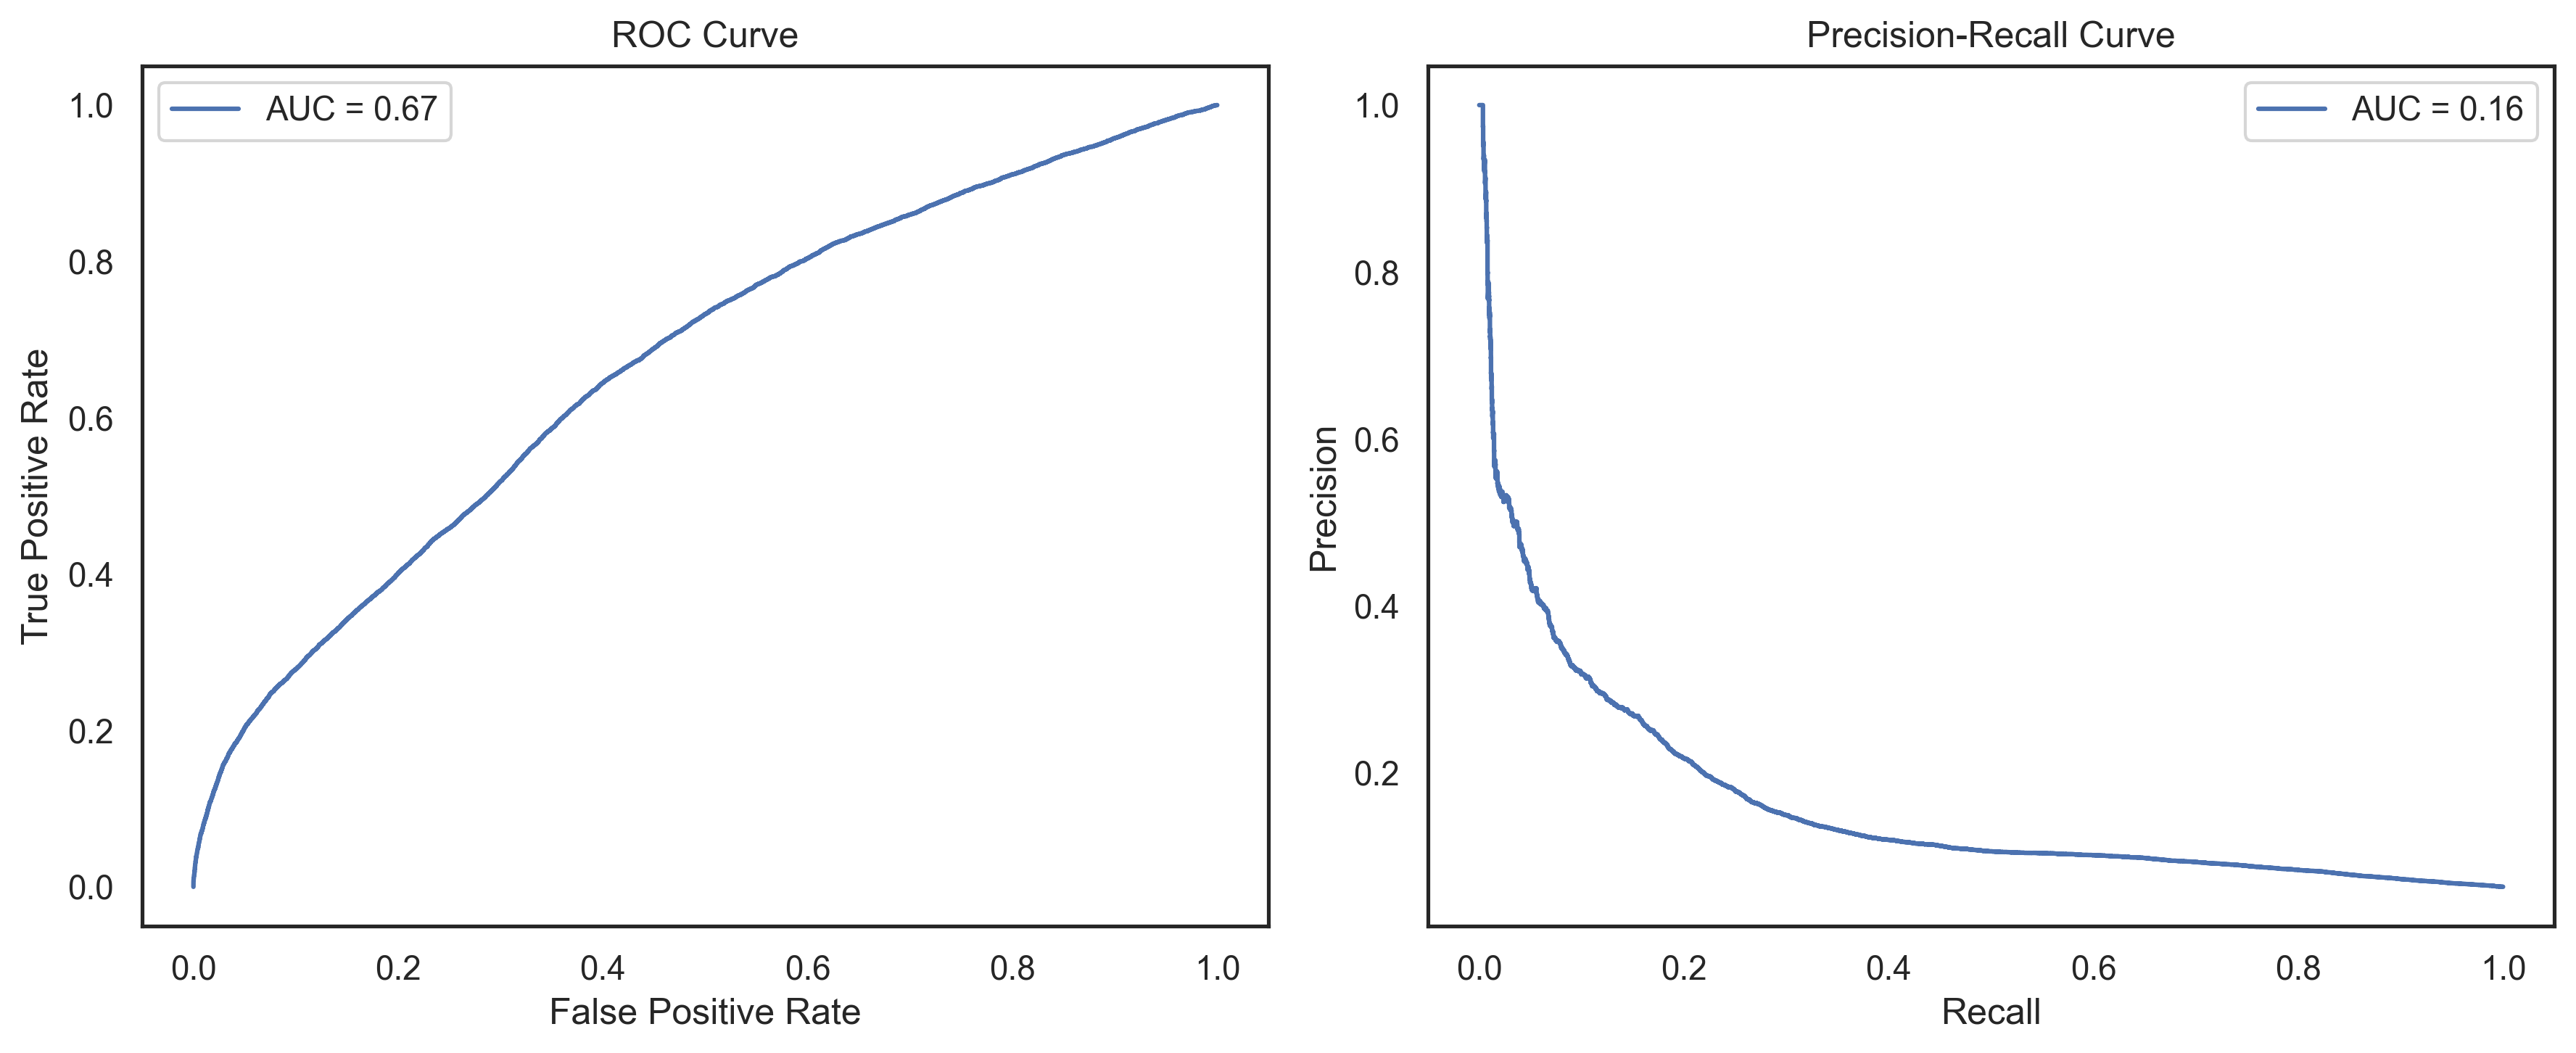

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(preds_with_truth["AD"], preds_with_truth["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
#plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
#plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Get thresholds from the precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])

# Calculate F1 score for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
best_f1 = f1_scores[best_index]

print(f"Best Threshold (by max F1): {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {best_f1:.4f}")

Best Threshold (by max F1): 0.2837
F1 Score at Best Threshold: 0.2103


# compare to input

In [10]:
human_yeast_preds_input = pd.read_csv("../output/human_yeast_aggreg_preds.tsv",     
            header=None
)
human_yeast_preds_input["uniprotID"] = human_yeast_preds_input[0].str.split(r"\t").str[0]
human_yeast_preds_input["values"] = human_yeast_preds_input[0].str.split(r"\t").str[2:]
human_yeast_preds_input["values"] = human_yeast_preds_input["values"].apply(lambda arr: [float(val) for val in arr if val != ""])
human_yeast_preds_input

,0,uniprotID,values
0,P23511\tMEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTE...,P23511,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Q96QS3\tMSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSP...,Q96QS3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,P31270\tMDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTP...,P31270,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
3,P50221\tMDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHY...,P50221,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,P57073\tMLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAG...,P57073,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
1850,Q707Y3\tMPSRTPTDIWRCQRLILAARKGETTCQALHEQSIEISS...,Q707Y3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1851,Q707Y6\tMQFTILNEPSLDSQRREGDLASENYVFGDIRKEGVRIL...,Q707Y6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1852,Q708A1\tMNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVIN...,Q708A1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1853,Q9HG12\tMCDNDMADIQSKLSSFCEEIRALALKEGYNLEGDKSPS...,Q9HG12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
human_yeast_preds_input["positions"] = [np.arange(1, len(v) + 1) for v in human_yeast_preds_input["values"]]
input_positions = human_yeast_preds_input.drop(columns = [0]).explode(["values", "positions"])
input_positions

,uniprotID,values,positions
0,P23511,0.0,1
0,P23511,0.0,2
0,P23511,0.0,3
0,P23511,0.0,4
0,P23511,0.0,5
...,...,...,...
1854,Q9HG13,0.0,253
1854,Q9HG13,0.0,254
1854,Q9HG13,0.0,255
1854,Q9HG13,0.0,256


In [12]:
input_with_truth = pd.merge(input_positions, known_ADs, how = 'left')
input_with_truth["AD"] = input_with_truth["AD"].fillna(0)
input_with_truth

,uniprotID,values,positions,AD
0,P23511,0.0,1,1.0
1,P23511,0.0,2,1.0
2,P23511,0.0,3,1.0
3,P23511,0.0,4,1.0
4,P23511,0.0,5,1.0
...,...,...,...,...
1090986,Q9HG13,0.0,253,0.0
1090987,Q9HG13,0.0,254,0.0
1090988,Q9HG13,0.0,255,0.0
1090989,Q9HG13,0.0,256,0.0


In [13]:
TF_lim_input = input_with_truth[input_with_truth["uniprotID"].isin(preds_with_truth["uniprotID"])]
TF_lim_input

,uniprotID,values,positions,AD
1222,P50221,0.0,1,0.0
1223,P50221,0.0,2,0.0
1224,P50221,0.0,3,0.0
1225,P50221,0.0,4,0.0
1226,P50221,0.0,5,0.0
...,...,...,...,...
1090198,Q707Y3,0.0,172,0.0
1090199,Q707Y3,0.0,173,0.0
1090200,Q707Y3,0.0,174,0.0
1090201,Q707Y3,0.0,175,0.0


In [22]:
# Get thresholds from the precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])

# Calculate F1 score for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
best_f1 = f1_scores[best_index]

print(f"Best Threshold (by max F1): {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {best_f1:.4f}")

Best Threshold (by max F1): 0.6000
F1 Score at Best Threshold: 0.2116


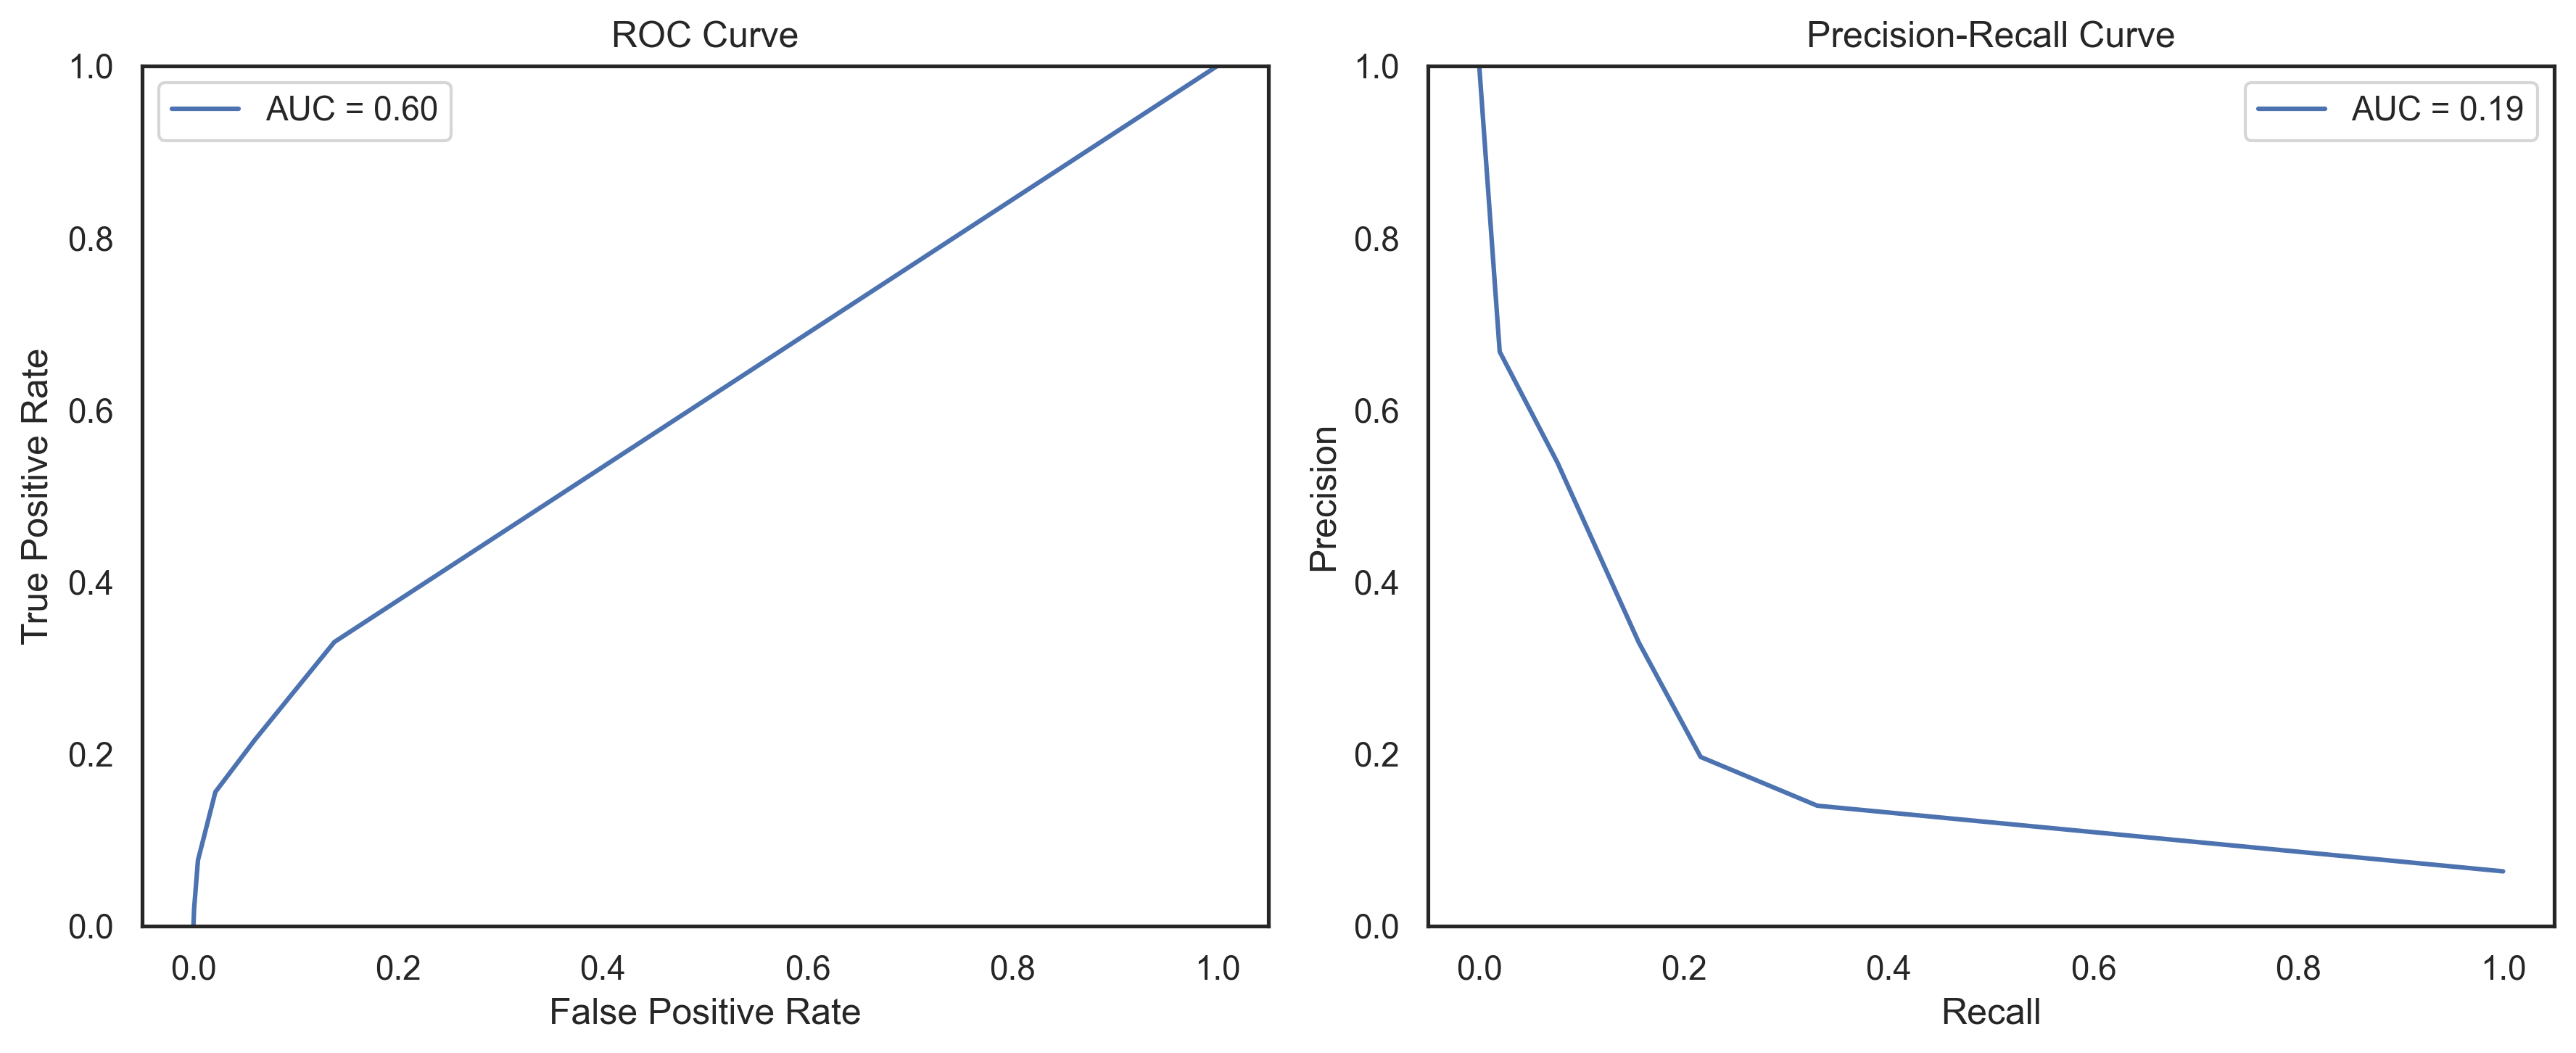

In [14]:
# ROC Curve
fpr, tpr, _ = roc_curve(TF_lim_input["AD"], TF_lim_input["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


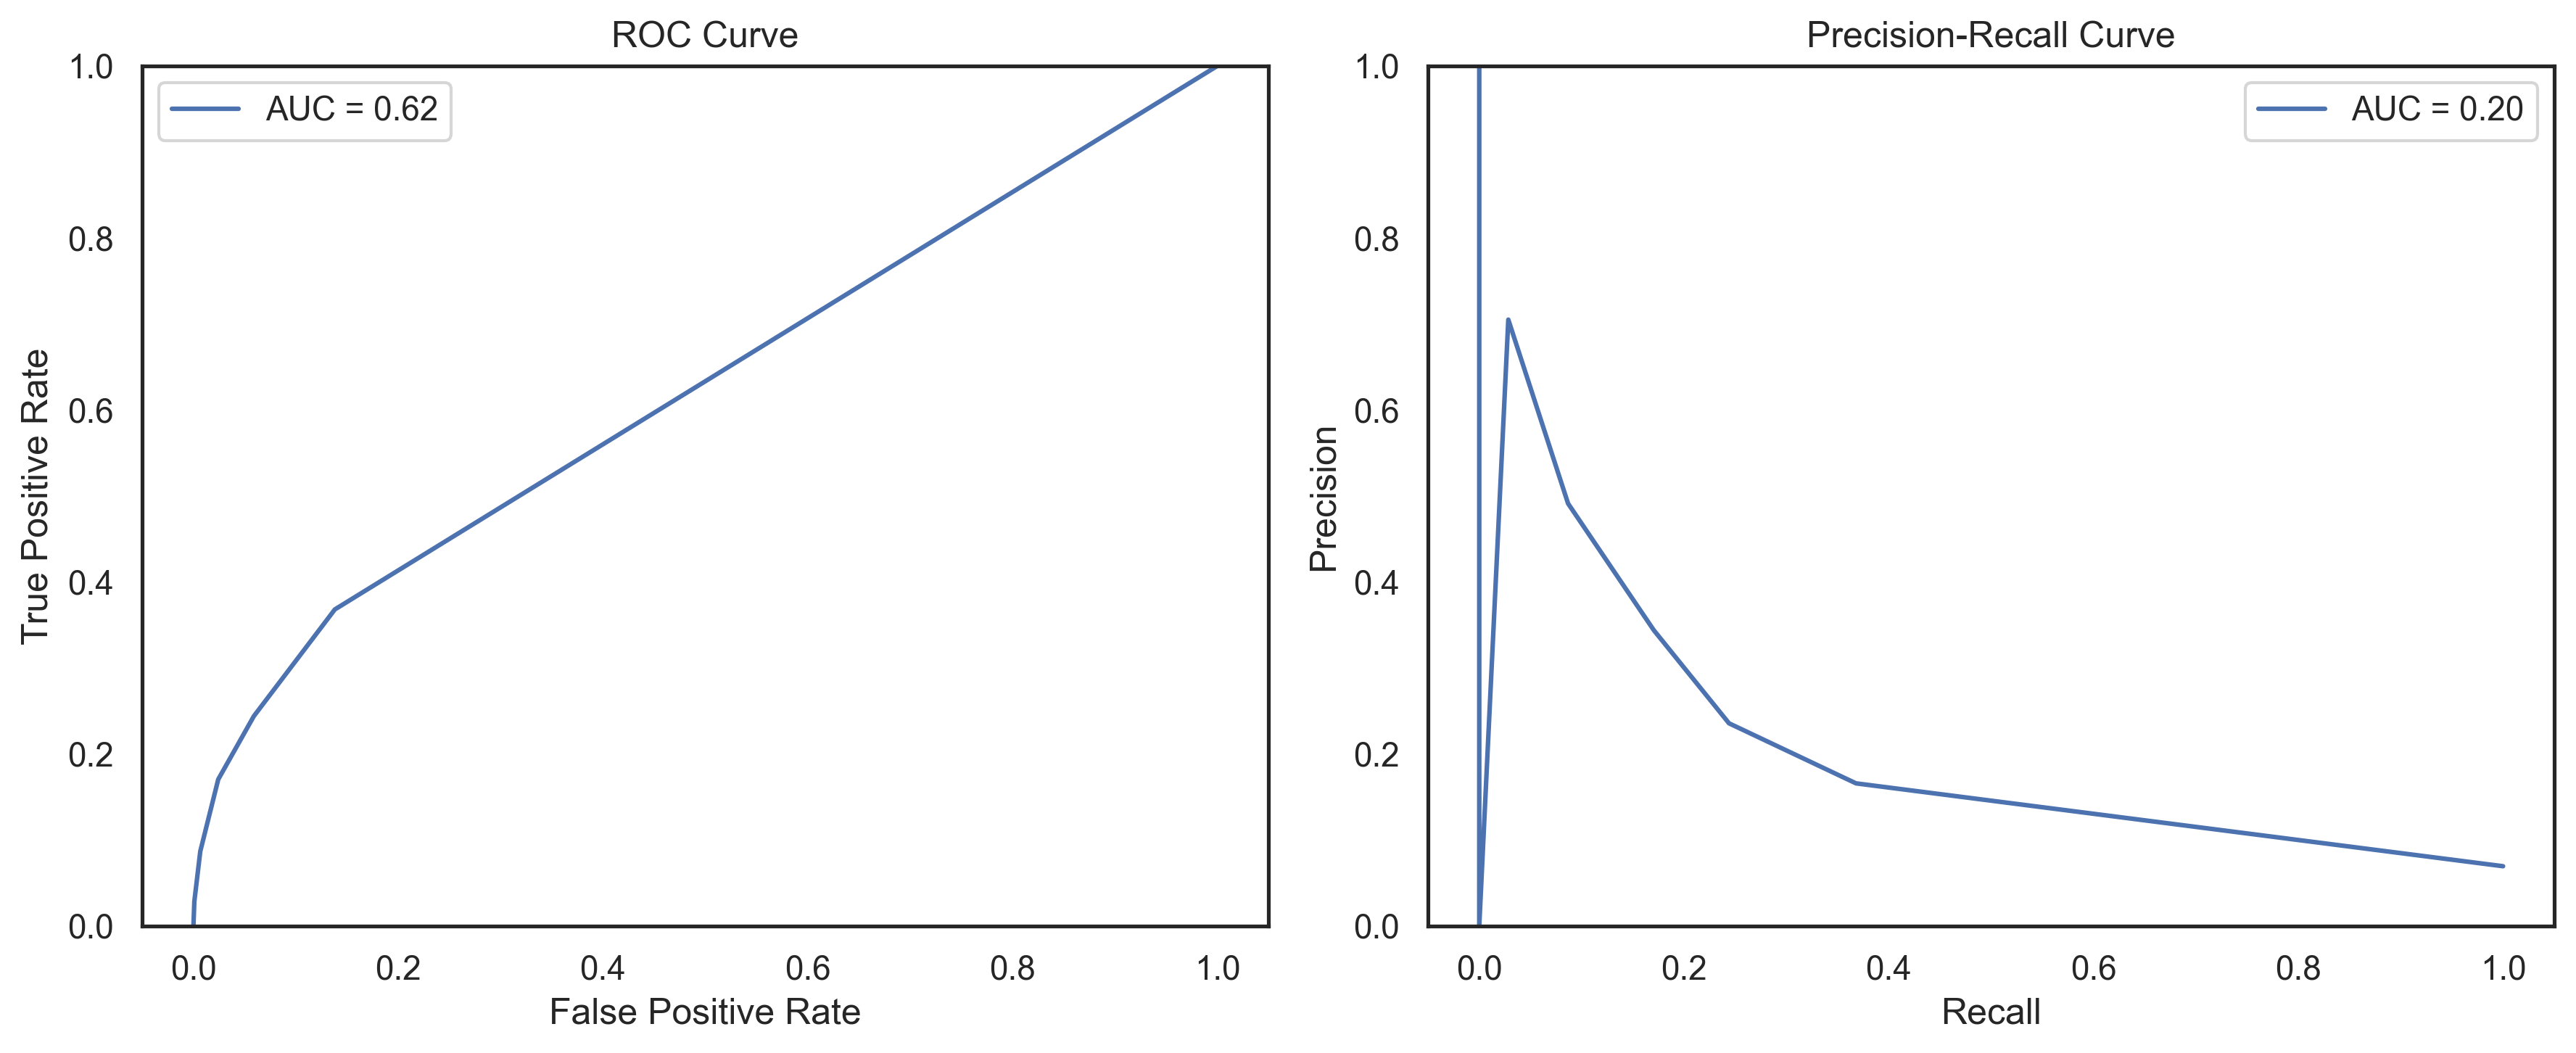

In [15]:
# ROC Curve
fpr, tpr, _ = roc_curve(input_with_truth["AD"], input_with_truth["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(input_with_truth["AD"], input_with_truth["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.1, 'PARROT Human + Yeast TF-Trained Consensus:\nTest Human TFs')

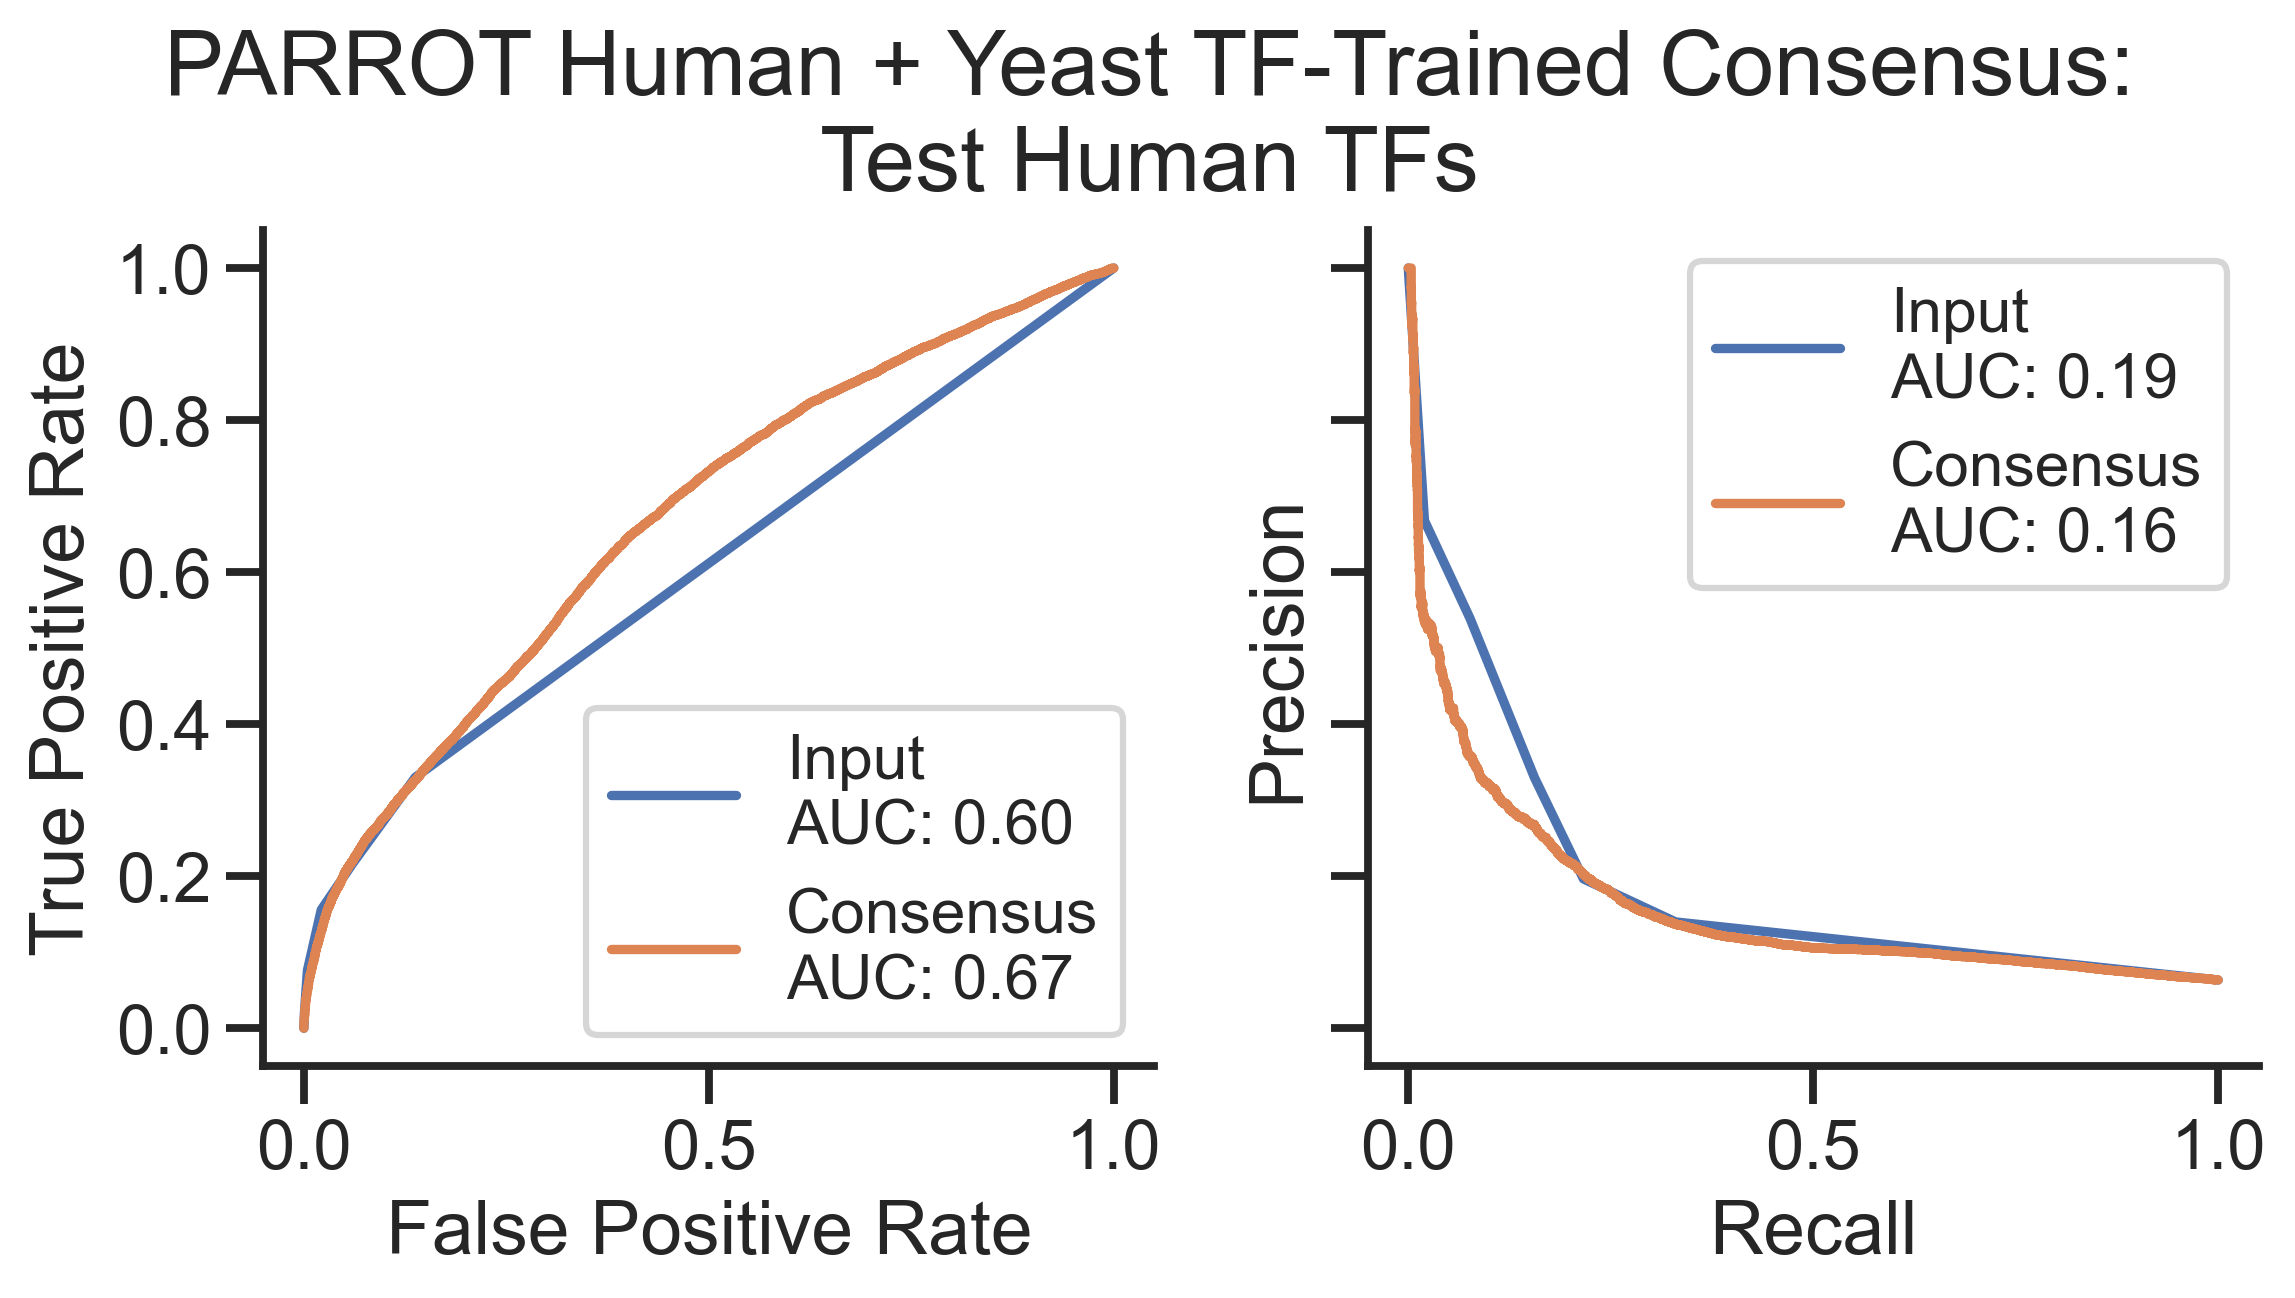

In [23]:
sns.set_context('talk')
sns.set_style('ticks')

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

## ROC

# Input
fpr, tpr, _ = roc_curve(TF_lim_input["AD"], TF_lim_input["values"])
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label=f"Input\nAUC: {roc_auc:.2f}")

# Preds
fpr, tpr, _ = roc_curve(preds_with_truth["AD"], preds_with_truth["values"])
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label=f"Consensus\nAUC: {roc_auc:.2f}")



axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(fontsize = 'small')

## PRC

# Input
precision, recall, _ = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])
prc_auc = auc(recall, precision)

axs[1].plot(recall, precision, label=f"Input\nAUC: {prc_auc:.2f}")

# Preds
precision, recall, _ = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])
prc_auc = auc(recall, precision)

axs[1].plot(recall, precision, label=f"Consensus\nAUC: {prc_auc:.2f}")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")


axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend(fontsize = 'small')

sns.despine()
plt.tight_layout()

plt.suptitle("PARROT Human + Yeast TF-Trained Consensus:\nTest Human TFs", y = 1.1)